### Mount Drive & Import Libraries

In [11]:
import os
import json
import string
import random
import numpy as np
import pprint
import matplotlib.pyplot as plt
from google.colab import drive
from collections import defaultdict

# --- Mount Drive ---
drive.mount('/content/drive')

# --- Configuration ---
BASE_PATH = '/content/drive/My Drive/ml-hackathon'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
REPORT_PATH = os.path.join(BASE_PATH, 'reports') # For saving plots

# --- Input Files (from Notebook 1 & 2) ---
CORPUS_JSON_PATH = os.path.join(DATA_PATH, 'corpus_by_length.json')
HMM_MODEL_PATH = os.path.join(MODEL_PATH, 'hmm_probabilities.json')

# --- Output Files ---
Q_TABLE_PATH = os.path.join(MODEL_PATH, 'q_table.json')
TRAINING_PLOT_PATH = os.path.join(REPORT_PATH, 'training_rewards.png')

print(f"Base path set to: {BASE_PATH}")
print(f"All models and data will be loaded.")
print(f"Trained Q-table will be saved to: {Q_TABLE_PATH}")
print(f"Training plot will be saved to: {TRAINING_PLOT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base path set to: /content/drive/My Drive/ml-hackathon
All models and data will be loaded.
Trained Q-table will be saved to: /content/drive/My Drive/ml-hackathon/models/q_table.json
Training plot will be saved to: /content/drive/My Drive/ml-hackathon/reports/training_rewards.png


### Load All Data

In [12]:
def load_json_file(file_path):
    """Loads a JSON file from the given path."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded: {file_path}")
        return data
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred loading {file_path}: {e}")
    return None

# --- Load Data ---
corpus_by_length = load_json_file(CORPUS_JSON_PATH)
hmm_models = load_json_file(HMM_MODEL_PATH)

# --- Data Correction ---
if corpus_by_length:
    corpus_by_length = {int(k): v for k, v in corpus_by_length.items()}
if hmm_models:
    hmm_models = {int(k): v for k, v in hmm_models.items()}

if corpus_by_length and hmm_models:
    print("\nAll data and models loaded successfully.")
else:
    print("\nError: Failed to load one or more essential files.")

# --- Constants ---
ALPHABET = list(string.ascii_uppercase)
LIVES_ALLOWED = 6

Successfully loaded: /content/drive/My Drive/ml-hackathon/data/corpus_by_length.json
Successfully loaded: /content/drive/My Drive/ml-hackathon/models/hmm_probabilities.json

All data and models loaded successfully.


Re-define the Hangman Environment

In [13]:
class HangmanEnvironment:
    """
    This class implements the Hangman game environment.
    (This is the same class from Notebook 3)
    """

    def __init__(self, word_list, lives=6):
        self.word_list = word_list
        self.total_lives = lives
        self.secret_word = ""
        self.masked_word = []
        self.lives_left = 0
        self.guessed_letters = set()
        self.game_over = True
        self.word_length = 0

    def reset(self):
        """Starts a new game."""
        self.secret_word = random.choice(self.word_list).upper()
        self.word_length = len(self.secret_word)
        self.masked_word = ["_"] * self.word_length
        self.lives_left = self.total_lives
        self.guessed_letters = set()
        self.game_over = False
        return self._get_current_state()

    def _get_current_state(self):
        """Returns the current state."""
        return {
            "masked_word": "".join(self.masked_word),
            "word_length": self.word_length,
            "lives_left": self.lives_left,
            "guessed_letters": sorted(list(self.guessed_letters)),
            "game_over": self.game_over
        }

    def step(self, action_letter):
        """Guesses a letter and returns the new state, reward, and game_over status."""
        if self.game_over:
            return self._get_current_state(), 0, True, {"error": "Game is already over."}

        action_letter = action_letter.upper()

        # --- REWARD FUNCTION ---
        # These match the final evaluation formula
        reward = 0
        info = {"guess_type": ""}

        # Case 1: Repeated guess
        if action_letter in self.guessed_letters:
            reward = -2  # Penalize repeated guesses
            info["guess_type"] = "repeated"

        # Case 2: Wrong guess
        elif action_letter not in self.secret_word:
            self.lives_left -= 1
            reward = -5  # Penalize wrong guesses
            self.guessed_letters.add(action_letter)
            info["guess_type"] = "wrong"

        # Case 3: Correct guess
        else:
            # A correct guess has no immediate penalty or reward
            # The only positive reward is WINNING.
            reward = 0
            self.guessed_letters.add(action_letter)
            info["guess_type"] = "correct"

            new_masked_word = list(self.masked_word)
            for i, char in enumerate(self.secret_word):
                if char == action_letter:
                    new_masked_word[i] = action_letter
            self.masked_word = new_masked_word

        # --- Check for Game Over ---
        if "_" not in self.masked_word:
            self.game_over = True
            # Success Rate * 2000 is 1 point per win
            reward = 1  # Bonus for winning
            info["game_result"] = "win"

        elif self.lives_left <= 0:
            self.game_over = True
            # No explicit penalty for losing, just the
            # accumulation of -5 penalties for wrong guesses.
            reward = 0
            info["game_result"] = "loss"

        return self._get_current_state(), reward, self.game_over, info

### The "HMM Oracle" (Letter Probability Calculator)

In [20]:
import re

def get_letter_probabilities(state, word_length):
    """
    This is our "HMM Oracle."
    It calculates the probability of each un-guessed letter.
    NOW, it returns a list of (letter, probability) tuples.
    """

    masked_word = state["masked_word"]
    guessed_letters = set(state["guessed_letters"])

    # Get the correct HMM model and word list
    model = hmm_models[word_length]
    word_list = corpus_by_length[word_length]

    pattern = ""
    for char in masked_word:
        if char == "_":
            pattern += f"[^{''.join(guessed_letters)}]"
        else:
            pattern += char

    try:
        regex = re.compile(f"^{pattern}$")
        candidate_words = [word for word in word_list if regex.match(word)]
    except:
        candidate_words = []

    letter_probs = defaultdict(float)

    if not candidate_words:
        # Fallback: Use UNIGRAM probability
        prob_model = model['unigram']
        for char in ALPHABET:
            if char not in guessed_letters:
                letter_probs[char] = prob_model.get(char, 1e-6)
    else:
        # Primary Strategy: Use candidate words
        blank_indices = [i for i, char in enumerate(masked_word) if char == "_"]
        total_blank_letters = 0

        for word in candidate_words:
            for i in blank_indices:
                letter_at_blank = word[i]
                if letter_at_blank not in guessed_letters:
                    letter_probs[letter_at_blank] += 1
                    total_blank_letters += 1

        if total_blank_letters > 0:
            for char in letter_probs:
                letter_probs[char] /= total_blank_letters

        if not letter_probs: # Failsafe
            prob_model = model['unigram']
            for char in ALPHABET:
                if char not in guessed_letters:
                    letter_probs[char] = prob_model.get(char, 1e-6)

    # 4. Sort the probabilities from high to low
    sorted_probs = sorted(letter_probs.items(), key=lambda item: item[1], reverse=True)

    return sorted_probs # e.g., [('A', 0.3), ('S', 0.1), ...]

### The Q-Learning Agent

In [21]:
class QLearningAgent:
    """
    This is the RL agent "brain".
    It uses Q-learning with a NEW, smarter abstracted state.
    """

    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=1.0):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon

        # --- State/Action Definitions ---
        # State: (lives_left, num_unique_letters_in_mask, prob_bin_of_best_guess)
        # This is our powerful state abstraction.

        # Actions: 0 = Guess best letter (from HMM)
        #          1 = Guess 2nd best letter
        #          2 = Guess 3rd best letter
        self.actions = [0, 1, 2]
        self.q_table = defaultdict(lambda: defaultdict(float))

    def _get_state_key(self, state, hmm_prob_info):
        """
        This is our NEW STATE ABSTRACTION function.
        It now includes the HMM's confidence.
        """
        lives = state["lives_left"]
        unique_letters_in_mask = len(set(c for c in state["masked_word"] if c != '_'))

        # Get the probability of the single best guess
        if not hmm_prob_info:
            best_prob = 0.0
        else:
            best_prob = hmm_prob_info[0][1] # (letter, prob)

        # Bin the probability into 10 groups (0-9)
        # e.g., 0.23 -> 2, 0.81 -> 8, 1.0 -> 10
        prob_bin = int(best_prob * 10)

        return f"L:{lives}_U:{unique_letters_in_mask}_P:{prob_bin}"

    def choose_action(self, state, hmm_prob_info):
        """
        Chooses an action using an epsilon-greedy policy.
        """
        if random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random action
            return random.choice(self.actions)
        else:
            # Exploitation: Choose the best action from the Q-table
            state_key = self._get_state_key(state, hmm_prob_info)
            q_values = self.q_table.get(state_key, {})

            if not q_values:
                return random.choice(self.actions) # Never seen, pick randomly

            # Find the action with the max Q-value
            return max(q_values, key=lambda k: q_values.get(k, 0.0))

    def learn(self, state, action, reward, next_state, hmm_prob_info, next_hmm_prob_info):
        """
        Updates the Q-table using the Bellman equation.
        """
        state_key = self._get_state_key(state, hmm_prob_info)
        next_state_key = self._get_state_key(next_state, next_hmm_prob_info)

        old_value = self.q_table.get(state_key, {}).get(action, 0.0)

        next_q_values = self.q_table.get(next_state_key, {})
        if not next_q_values:
            next_max = 0.0
        else:
            next_max = max(next_q_values.values())

        new_value = old_value + self.lr * (reward + self.gamma * next_max - old_value)
        self.q_table[state_key][action] = new_value

    def save_q_table(self, file_path):
        """Saves the learned Q-table to a file."""
        # Convert all keys to strings for JSON
        string_key_q_table = {}
        for state, actions in self.q_table.items():
            string_key_q_table[state] = {str(k): v for k, v in actions.items()}

        with open(file_path, 'w') as f:
            json.dump(string_key_q_table, f)
        print(f"Q-table saved to {file_path}")

    def load_q_table(self, file_path):
        """Loads a pre-trained Q-table."""
        with open(file_path, 'r') as f:
            self.q_table = json.load(f)
        print(f"Q-table loaded from {file_path}")

### The Training Loop

In [22]:
# --- Training Parameters ---
NUM_TRAINING_EPISODES = 20000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.9999

print("Initializing Agent and Environment for Training...")

agent = QLearningAgent(
    learning_rate=0.1,
    discount_factor=0.9,
    epsilon=EPSILON_START
)

all_corpus_words = [word for words in corpus_by_length.values() for word in words]
train_env = HangmanEnvironment(word_list=all_corpus_words, lives=LIVES_ALLOWED)

print(f"Training on a corpus of {len(all_corpus_words)} words.")
print(f"Running {NUM_TRAINING_EPISODES} training episodes...")

episode_rewards = []
episode_numbers = []

for episode in range(NUM_TRAINING_EPISODES):
    state = train_env.reset()
    word_length = state["word_length"]
    total_reward = 0
    game_over = False

    while not game_over:
        # 1. Get HMM info FOR THE CURRENT STATE
        hmm_prob_info = get_letter_probabilities(state, word_length)

        # 2. Agent chooses an ACTION (0, 1, or 2)
        action = agent.choose_action(state, hmm_prob_info)

        # 3. Translate the ACTION into a LETTER
        guess = None
        if action == 0 and len(hmm_prob_info) > 0:
            guess = hmm_prob_info[0][0] # Action 0: Best guess
        elif action == 1 and len(hmm_prob_info) > 1:
            guess = hmm_prob_info[1][0] # Action 1: 2nd best
        elif action == 2 and len(hmm_prob_info) > 2:
            guess = hmm_prob_info[2][0] # Action 2: 3rd best
        else:
            # Failsafe: cascade down or pick randomly if HMM is empty
            if len(hmm_prob_info) > 0:
                guess = hmm_prob_info[0][0]
            else:
                available_letters = [l for l in ALPHABET if l not in state["guessed_letters"]]
                if available_letters:
                    guess = random.choice(available_letters)
                else:
                    break

        # 4. Agent takes the step
        next_state, reward, game_over, info = train_env.step(guess)

        # 5. Get HMM info FOR THE NEXT STATE
        next_hmm_prob_info = get_letter_probabilities(next_state, word_length)

        # 6. Agent learns from the result
        agent.learn(state, action, reward, next_state, hmm_prob_info, next_hmm_prob_info)

        state = next_state
        total_reward += reward

    # --- End of Episode ---
    if agent.epsilon > EPSILON_END:
        agent.epsilon *= EPSILON_DECAY

    if (episode + 1) % 1000 == 0:
        print(f"Episode: {episode + 1}/{NUM_TRAINING_EPISODES} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")
        episode_rewards.append(total_reward)
        episode_numbers.append(episode + 1)

print("\n--- Training Complete ---")
agent.save_q_table(Q_TABLE_PATH)

Initializing Agent and Environment for Training...
Training on a corpus of 49979 words.
Running 20000 training episodes...
Episode: 1000/20000 | Total Reward: -4.00 | Epsilon: 0.9048
Episode: 2000/20000 | Total Reward: 1.00 | Epsilon: 0.8187
Episode: 3000/20000 | Total Reward: -4.00 | Epsilon: 0.7408
Episode: 4000/20000 | Total Reward: 1.00 | Epsilon: 0.6703
Episode: 5000/20000 | Total Reward: -4.00 | Epsilon: 0.6065
Episode: 6000/20000 | Total Reward: -4.00 | Epsilon: 0.5488
Episode: 7000/20000 | Total Reward: -9.00 | Epsilon: 0.4966
Episode: 8000/20000 | Total Reward: -14.00 | Epsilon: 0.4493
Episode: 9000/20000 | Total Reward: -4.00 | Epsilon: 0.4066
Episode: 10000/20000 | Total Reward: -14.00 | Epsilon: 0.3679
Episode: 11000/20000 | Total Reward: 1.00 | Epsilon: 0.3329
Episode: 12000/20000 | Total Reward: -4.00 | Epsilon: 0.3012
Episode: 13000/20000 | Total Reward: -9.00 | Epsilon: 0.2725
Episode: 14000/20000 | Total Reward: 1.00 | Epsilon: 0.2466
Episode: 15000/20000 | Total Rewar

### Plot Training Progress

Plotting training progress...
Training plot saved to: /content/drive/My Drive/ml-hackathon/reports/training_rewards.png


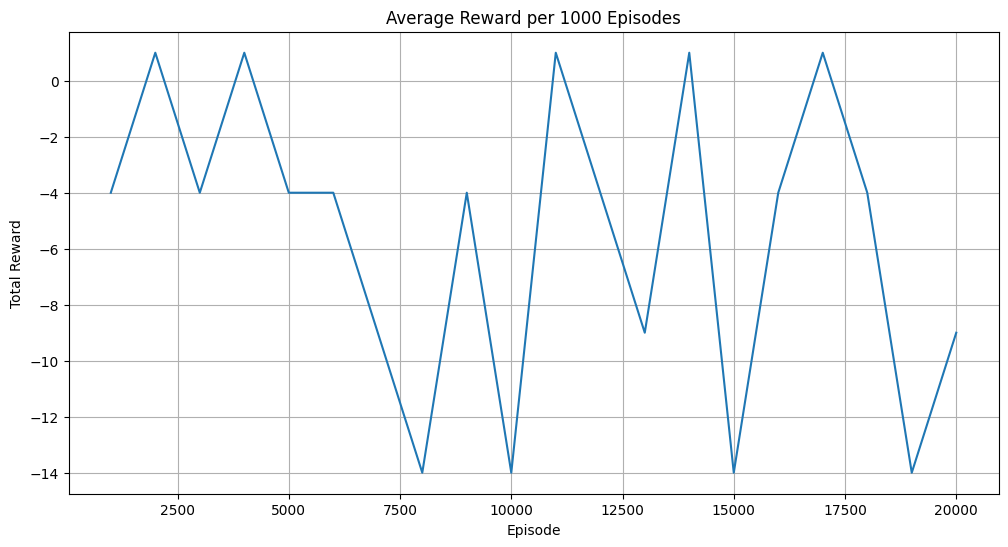

In [23]:
print("Plotting training progress...")

plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, episode_rewards)
plt.title('Average Reward per 1000 Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Save the plot to Google Drive
plt.savefig(TRAINING_PLOT_PATH)
print(f"Training plot saved to: {TRAINING_PLOT_PATH}")

# Show the plot
plt.show()